In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import

In [ ]:
import pandas as pd
import numpy as np
from pprint import pprint
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import time
from _operator import itemgetter
from math import sqrt
import random 
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
path="drive/My Drive/1001_project_Total/Data/"
df1=pd.read_csv(path+"20170101_prestage.csv")

In [4]:
df=df1.drop("Unnamed: 0",1)
df.columns

Index(['profile', 'category1', 'canonicalUrl', 'referrerHostClass',
       'sessionStop', 'userId', 'publishtime', 'sessionStart', 'referrerUrl',
       'keywords', 'id', 'eventId', 'city', 'title', 'url', 'country',
       'region', 'author', 'referrerSearchEngine', 'deviceType', 'time', 'os',
       'activeTime', 'sessionNo', 'activeTotalTime', 'articleId'],
      dtype='object')

In [5]:
print(len(df))
print(len(df["city"].unique()))
print(len(df["region"].unique()))

374487
2039
497


# Choose Variables

In [6]:
articles=df["id"].unique()
d={}
for i in range(len(articles)):
    article=articles[i]
    d[article]=i
df["articleId"]=df["id"].map(d)
df.columns

Index(['profile', 'category1', 'canonicalUrl', 'referrerHostClass',
       'sessionStop', 'userId', 'publishtime', 'sessionStart', 'referrerUrl',
       'keywords', 'id', 'eventId', 'city', 'title', 'url', 'country',
       'region', 'author', 'referrerSearchEngine', 'deviceType', 'time', 'os',
       'activeTime', 'sessionNo', 'activeTotalTime', 'articleId'],
      dtype='object')

In [7]:
#data=df[["sessionNo","category_num","time"]].rename(columns={"sessionNo":"session_key","category_num": "item_key", "time":"time_key"})
data_1=df[["sessionNo","articleId","time","city","region","deviceType"]].rename(columns={"sessionNo":"session_key","articleId": "item_key", "time":"time_key"})
print("The length of data with article as itemid: ",len(data_1))
data_1.head()

The length of data with article as itemid:  374487


,session_key,item_key,time_key,city,region,deviceType
0,2,0,1483305738,oslo,oslo,Desktop
1,2,1,1483305786,oslo,oslo,Desktop
2,2,2,1483305801,oslo,oslo,Desktop
3,4,3,1483260265,brumunddal,hedmark,Desktop
4,5,4,1483271454,brumunddal,hedmark,Desktop


In [ ]:
categories=df["category1"].unique()
d={}
for i in range(len(categories)):
    category=categories[i]
    d[category]=i
df["categoryId"]=df["category1"].map(d)

In [9]:
#data=df[["sessionNo","category_num","time"]].rename(columns={"sessionNo":"session_key","category_num": "item_key", "time":"time_key"})
data_2=df[["sessionNo","categoryId","time","city","region","deviceType"]].rename(columns={"sessionNo":"session_key","categoryId": "item_key", "time":"time_key"})
print("The length of data with category as itemid: ",len(data_2))
data_2.head()

The length of data with category as itemid:  374487


,session_key,item_key,time_key,city,region,deviceType
0,2,0,1483305738,oslo,oslo,Desktop
1,2,1,1483305786,oslo,oslo,Desktop
2,2,1,1483305801,oslo,oslo,Desktop
3,4,0,1483260265,brumunddal,hedmark,Desktop
4,5,2,1483271454,brumunddal,hedmark,Desktop


## DeviceType

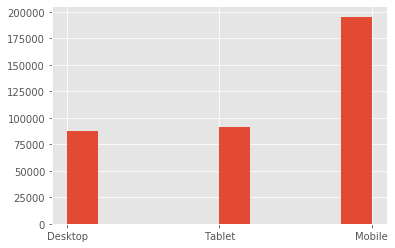

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
fig=plt.hist(data_1["deviceType"])

In [11]:
t=pd.get_dummies(data_1["deviceType"])
device_data=data_1.join(t)
device_data.to_csv(path+"day_one_article_only_device.csv")
device_data.head()

,session_key,item_key,time_key,city,region,deviceType,Desktop,Mobile,Tablet
0,2,0,1483305738,oslo,oslo,Desktop,1,0,0
1,2,1,1483305786,oslo,oslo,Desktop,1,0,0
2,2,2,1483305801,oslo,oslo,Desktop,1,0,0
3,4,3,1483260265,brumunddal,hedmark,Desktop,1,0,0
4,5,4,1483271454,brumunddal,hedmark,Desktop,1,0,0


In [12]:
t=pd.get_dummies(data_2["deviceType"])
device_data=data_2.join(t)
device_data.to_csv(path+"day_one_category_only_device.csv")
device_data.head()

,session_key,item_key,time_key,city,region,deviceType,Desktop,Mobile,Tablet
0,2,0,1483305738,oslo,oslo,Desktop,1,0,0
1,2,1,1483305786,oslo,oslo,Desktop,1,0,0
2,2,1,1483305801,oslo,oslo,Desktop,1,0,0
3,4,0,1483260265,brumunddal,hedmark,Desktop,1,0,0
4,5,2,1483271454,brumunddal,hedmark,Desktop,1,0,0


## Regions

In [13]:
k=data_1.groupby("region")["session_key"].count()
k.describe()

count       496.000000
mean        754.616935
std       10639.337693
min           1.000000
25%           2.000000
50%           4.000000
75%          13.000000
max      227906.000000
Name: session_key, dtype: float64

In [14]:
from geopy.geocoders import Nominatim
from tqdm import tqdm
geolocator = Nominatim(user_agent="specify_your_app_name_here")
d={}
k=data_1["region"].unique()
for i in tqdm(range(len(k))):
    try:
      location = geolocator.geocode(i)
      if not location:
          d[k[i]]=(0,0)
      else:
          d[k[i]]=(location.latitude, location.longitude)
    except:
      print(111)
      d[k[i]]=(0,0)

 82%|████████▏ | 406/497 [07:39<01:45,  1.16s/it]

111


100%|██████████| 497/497 [09:19<00:00,  1.08s/it]


In [ ]:
l=[[],[]]
for v,k in zip(d.values(),d.keys()):
  if d[k]!=(0,0):
    l[0].append(d[k][0])
    l[1].append(d[k][1])
mean=(sum(l[0])/len(l[0]),sum(l[1])/len(l[1]))
for v,k in zip(d.values(),d.keys()):
  if d[k]==(0,0):
    d[k]=mean

In [16]:
tmp=data_1["region"].map(d)
region_data=data_1
region_data["lat"]=tmp.apply(lambda x:x[0])
region_data["long"]=tmp.apply(lambda x:x[1])
region_data.to_csv(path+"day_one_article_only_region.csv")
region_data.head()

,session_key,item_key,time_key,city,region,deviceType,lat,long
0,2,0,1483305738,oslo,oslo,Desktop,47.361750,27.778029
1,2,1,1483305786,oslo,oslo,Desktop,47.361750,27.778029
2,2,2,1483305801,oslo,oslo,Desktop,47.361750,27.778029
3,4,3,1483260265,brumunddal,hedmark,Desktop,22.351115,78.667743
4,5,4,1483271454,brumunddal,hedmark,Desktop,22.351115,78.667743


In [17]:
tmp=data_2["region"].map(d)
region_data=data_2
region_data["lat"]=tmp.apply(lambda x:x[0])
region_data["long"]=tmp.apply(lambda x:x[1])
region_data.to_csv(path+"day_one_category_only_region.csv")
region_data.head()

,session_key,item_key,time_key,city,region,deviceType,lat,long
0,2,0,1483305738,oslo,oslo,Desktop,47.361750,27.778029
1,2,1,1483305786,oslo,oslo,Desktop,47.361750,27.778029
2,2,1,1483305801,oslo,oslo,Desktop,47.361750,27.778029
3,4,0,1483260265,brumunddal,hedmark,Desktop,22.351115,78.667743
4,5,2,1483271454,brumunddal,hedmark,Desktop,22.351115,78.667743


## Combine

In [18]:
region=pd.read_csv(path+"day_one_article_only_region.csv")
device=pd.read_csv(path+"day_one_article_only_device.csv")
region.head(),device.head()

(   Unnamed: 0  session_key  item_key  ...  deviceType        lat       long
 0           0            2         0  ...     Desktop  47.361750  27.778029
 1           1            2         1  ...     Desktop  47.361750  27.778029
 2           2            2         2  ...     Desktop  47.361750  27.778029
 3           3            4         3  ...     Desktop  22.351115  78.667743
 4           4            5         4  ...     Desktop  22.351115  78.667743
 
 [5 rows x 9 columns],
    Unnamed: 0  session_key  item_key  ...  Desktop Mobile Tablet
 0           0            2         0  ...        1      0      0
 1           1            2         1  ...        1      0      0
 2           2            2         2  ...        1      0      0
 3           3            4         3  ...        1      0      0
 4           4            5         4  ...        1      0      0
 
 [5 rows x 10 columns])

In [19]:
device=device[["Desktop","Mobile","Tablet"]]
combine=region.join(device)
combine.to_csv(path+"day_one_article_region_device.csv")
combine.head()

,Unnamed: 0,session_key,item_key,time_key,city,region,deviceType,lat,long,Desktop,Mobile,Tablet
0,0,2,0,1483305738,oslo,oslo,Desktop,47.361750,27.778029,1,0,0
1,1,2,1,1483305786,oslo,oslo,Desktop,47.361750,27.778029,1,0,0
2,2,2,2,1483305801,oslo,oslo,Desktop,47.361750,27.778029,1,0,0
3,3,4,3,1483260265,brumunddal,hedmark,Desktop,22.351115,78.667743,1,0,0
4,4,5,4,1483271454,brumunddal,hedmark,Desktop,22.351115,78.667743,1,0,0


In [20]:
region=pd.read_csv(path+"day_one_category_only_region.csv")
device=pd.read_csv(path+"day_one_category_only_device.csv")
region.head(),device.head()

(   Unnamed: 0  session_key  item_key  ...  deviceType        lat       long
 0           0            2         0  ...     Desktop  47.361750  27.778029
 1           1            2         1  ...     Desktop  47.361750  27.778029
 2           2            2         1  ...     Desktop  47.361750  27.778029
 3           3            4         0  ...     Desktop  22.351115  78.667743
 4           4            5         2  ...     Desktop  22.351115  78.667743
 
 [5 rows x 9 columns],
    Unnamed: 0  session_key  item_key  ...  Desktop Mobile Tablet
 0           0            2         0  ...        1      0      0
 1           1            2         1  ...        1      0      0
 2           2            2         1  ...        1      0      0
 3           3            4         0  ...        1      0      0
 4           4            5         2  ...        1      0      0
 
 [5 rows x 10 columns])

In [21]:
device=device[["Desktop","Mobile","Tablet"]]
combine=region.join(device)
combine.to_csv(path+"day_one_category_region_device.csv")
combine.head()

,Unnamed: 0,session_key,item_key,time_key,city,region,deviceType,lat,long,Desktop,Mobile,Tablet
0,0,2,0,1483305738,oslo,oslo,Desktop,47.361750,27.778029,1,0,0
1,1,2,1,1483305786,oslo,oslo,Desktop,47.361750,27.778029,1,0,0
2,2,2,1,1483305801,oslo,oslo,Desktop,47.361750,27.778029,1,0,0
3,3,4,0,1483260265,brumunddal,hedmark,Desktop,22.351115,78.667743,1,0,0
4,4,5,2,1483271454,brumunddal,hedmark,Desktop,22.351115,78.667743,1,0,0
